# Regression Analysis - ML and DL Comparison


In this notebook, we will perform regression on the **California Housing Dataset** using both Machine Learning (ML) and Deep Learning (DL) models.

We will cover the following steps:
1. Data Loading and Preprocessing
2. Feature Engineering
3. Exploratory data analysis (EDA)
4. Model Training
5. Visualization and Interpretability Analysis (SHAP for explainability (ML))
6. Model Evaluation: Performance Metrics
7. Opportunities for enhancement


**ML**: Linear Regression, Random Forest, XGBoost + tuning

**DL**: Feedforward Neural Network with regularization and tuning

**Metrics**: RMSE, MAE, R²


## Data Loading and Preprocessing

#### Importing libraries

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import os
import shutil
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

### Load the California Housing Dataset
We will start by loading the **California Housing Dataset**, which contains various features about housing prices in California. This dataset is commonly used for regression tasks.

We use a dataset with:

8 features: e.g., average income, rooms, population

1 target:  `MedHouseVal` = median house value


Features like income, rooms, population → Target: median house value

In [104]:
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target, name='MedHouseVal')
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [103]:
print(X.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741     33.930000   -1

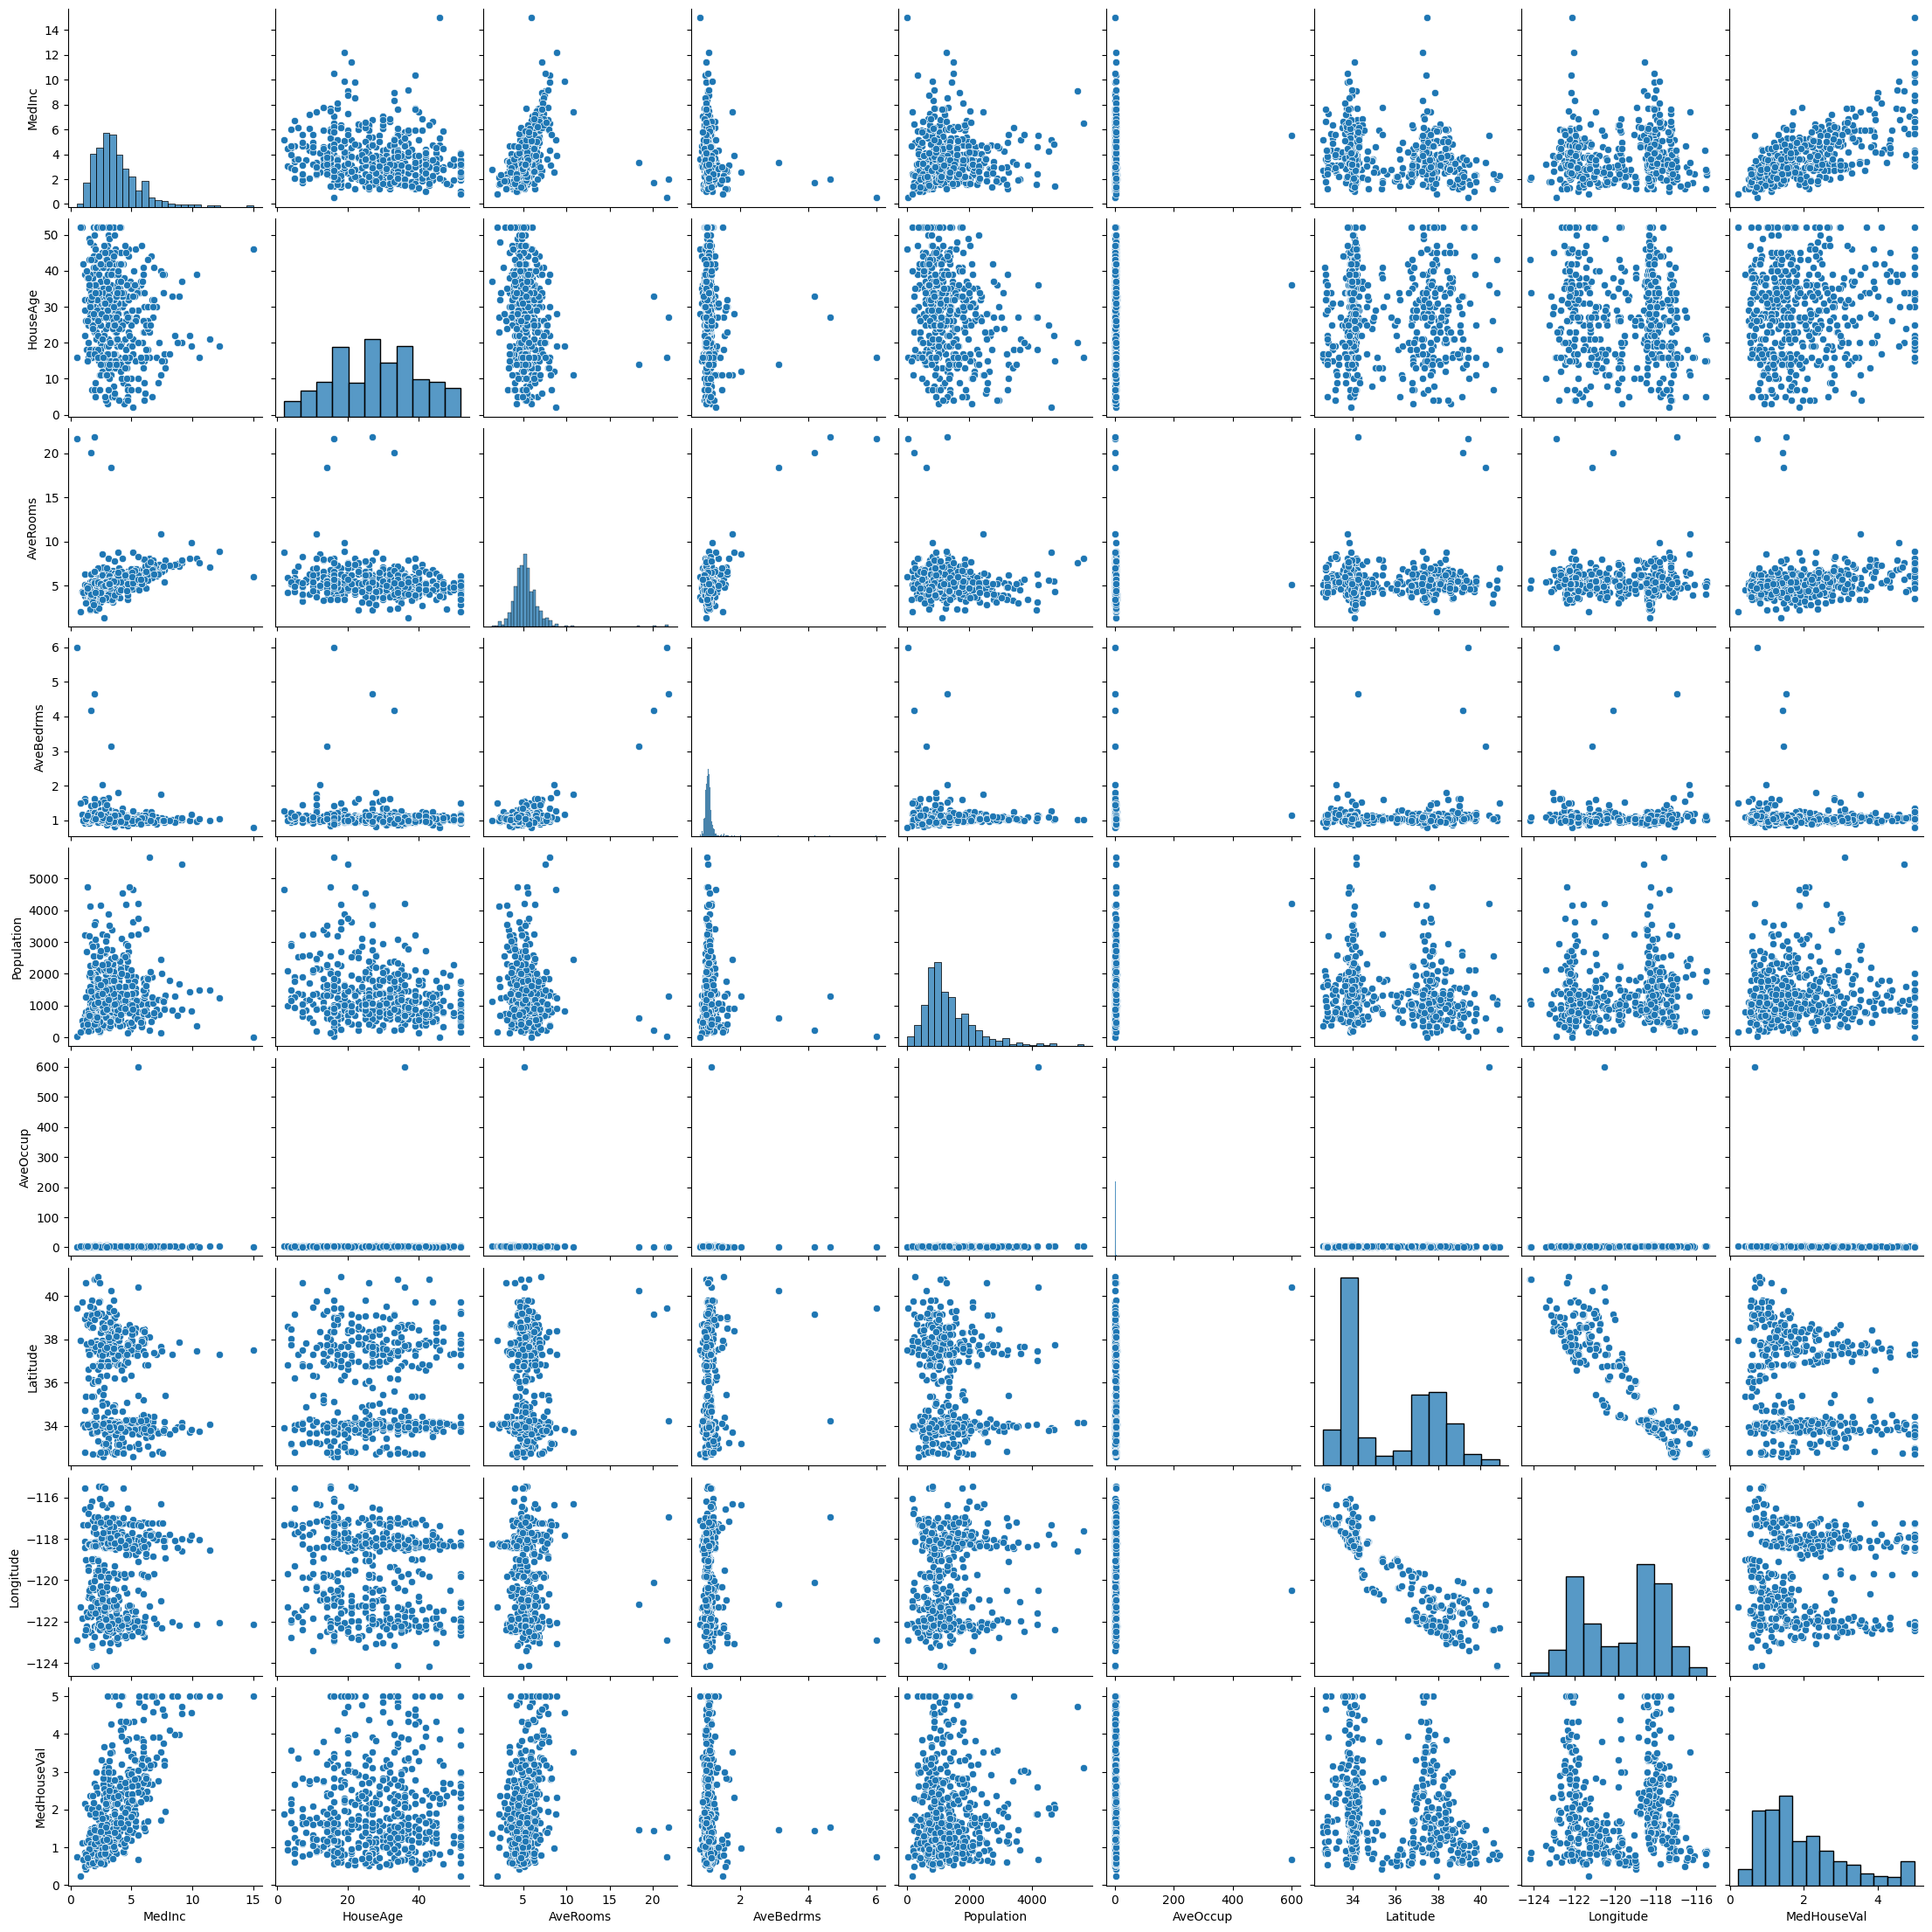

In [105]:
sns.pairplot(pd.concat([X, y], axis=1).sample(500))
plt.show()

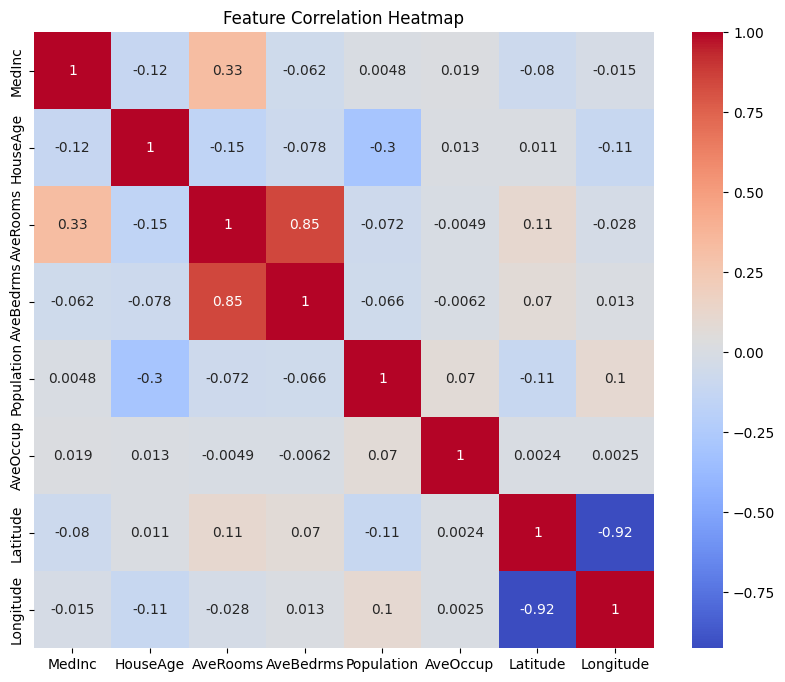

In [102]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

## Feature Engineering

Feature engineering is the process of creating new features or transforming existing features to improve model performance. Here, we create two new features:



We create new features to help the model:

`RoomsPerPerson = AveRooms / AveOccup`

(more intuitive than treating them separately)

`LogPopulation = log(Population + 1)`

(to deal with skewed population values)

These improve model learning by offering better structure.

- `RoomsPerPerson`: the average number of rooms per person
- `LogPopulation`: the logarithm of the population (to reduce skewness and handle outliers)


**Interaction terms** (e.g., AveRooms * AveOccup)

**Polynomial features** (useful in linear models)

**Log-transform skewed features** (e.g., population)

**Binning or quantile cuts** (e.g., discretizing features)

In [ ]:
# Feature Engineering
X['RoomsPerPerson'] = X['AveRooms'] / X['AveOccup']
X['LogPopulation'] = np.log(X['Population'] + 1)
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,RoomsPerPerson,LogPopulation
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,2.732919,5.777652
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,2.956685,7.784057
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,2.957661,6.208590
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,2.283154,6.326149
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,2.879646,6.338594


## Exploratory Data Analysis



### Outlier Detection & Handling

Removed extreme values using Z-score to avoid noisy training. This helps the model focus on the normal patterns.
1. Use **z-scores or IQR** to remove/flag outliers.
2. Visualize with boxplots or scatterplots before training.

In [107]:
# Data Preprocessing
from scipy import stats
z_scores = np.abs(stats.zscore(X))
X = X[(z_scores < 3).all(axis=1)]
y = y.loc[X.index]

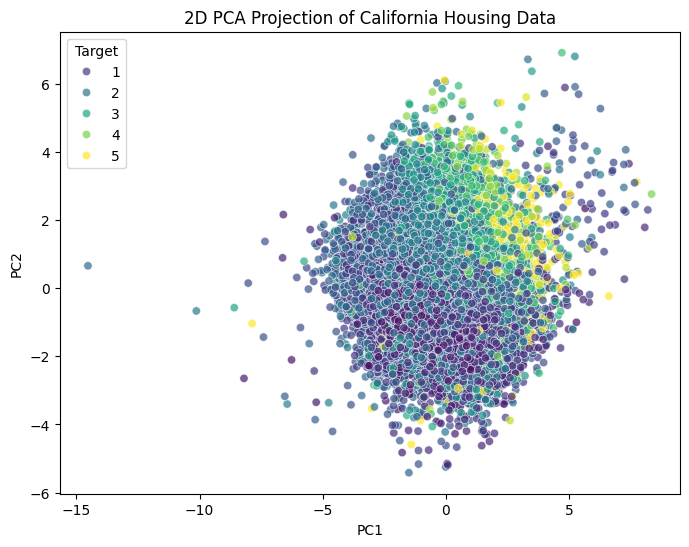

In [ ]:
# Let's assume your features are in X (after outlier removal and feature engineering)
# and the target variable is in y

# 1. Standardize features (again, if not already)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Try reducing to 2 components for visualization (not model input)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Visualize PCA-reduced data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=y, palette='viridis', alpha=0.7)
plt.title("2D PCA Projection of California Housing Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Target", loc="best")
plt.show()


## Model Training




### Train/Test Split
Next, we split the dataset into **training** and **test** sets.

80% training, 20% testing

In [ ]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((15643, 10), (3911, 10))

### Feature Scaling
Some machine learning algorithms, such as neural networks, are sensitive to the scale of the data. So, we will scale the features (normalize them to a standard range) using **StandardScaler**.

Standardized input features (mean = 0, std = 1)

In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Machine Learning

Multiple Models Used

1. Linear Regression (baseline)
2. Random Forest (with hyperparameter tuning)
3. XGBoost (with tuning)
4. Stacking Regressor (ensemble of above models)

### Machine Learning Model: Linear Regression
We can combine the predictions as baseline model.

In [ ]:
# Train with Linear Regression
lr = LinearRegression()

# Train the model
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

rmse_lr, mae_lr, r2_lr

(0.6484602039866608, 0.4815256101707194, 0.6549840384350865)

### Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV for:

**Random Forest**: `n_estimators`, `max_depth`, `min_samples_split`, `max_features`

**XGBoost**: `learning_rate`, `max_depth`, `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`

### Machine Learning Model: XGBoost Regressor
We will start by training an **XGBoost Regressor**. XGBoost is a popular algorithm based on decision trees that often gives great results in regression tasks.

In [ ]:
# 8. XGBoost with Hyperparameter Tuning
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}
xgb_search = RandomizedSearchCV(xgb, xgb_params, cv=5, scoring='neg_root_mean_squared_error', n_iter=10, n_jobs=-1)
xgb_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8, 1]},
                   scoring='neg_root_mean_squared_error')

In [ ]:
# ML Model 1: XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=200, learning_rate =  0.1, 
                         max_depth= 4, subsample= 0.8, 
                         colsample_bytree= 0.8, random_state=42, verbosity=0)

# Train the model
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

rmse_xgb, mae_xgb, r2_xgb

(0.46958791427594176, 0.32324579444113, 0.8190717626231612)

### Machine Learning Model: Random Forest Regressor
Random Forest is another powerful tree-based model. It builds many decision trees and averages their predictions for more robust results.

In [ ]:
# 7. Cross-validated Random Forest with Hyperparameter Tuning
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': [1.0, 'sqrt', 'log2']
}
rf_search = RandomizedSearchCV(rf, rf_params, cv=5, scoring='neg_root_mean_squared_error', n_iter=10, n_jobs=-1)
rf_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': [1.0, 'sqrt', 'log2'],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]},
                   scoring='neg_root_mean_squared_error')

In [ ]:
# ML Model 2: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=200, max_features='log2', random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

rmse_rf, mae_rf, r2_rf

(0.501199419410795, 0.33842410470467926, 0.7938925696581186)

### Machine Learning : Stacked Model: Model Stacking or Voting Ensembles
We can combine the predictions of multiple models using **stacking**. Combine predictions of LR, RF, XGBoost using StackingRegressor or VotingRegressor for improved performance. Here, we stack the XGBoost and Random Forest models, using a **RandomForestRegressor** to combine their predictions.




In [ ]:
# Stacking Model: Combine XGBoost and Random Forest
stack_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the stacking model using predictions from XGBoost and Random Forest
stack_model.fit(np.column_stack((y_pred_xgb, y_pred_rf)), y_test)
y_pred_stack = stack_model.predict(np.column_stack((y_pred_xgb, y_pred_rf)))

rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
mae_stack = mean_absolute_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

rmse_stack, mae_stack, r2_stack

(0.1940034187545683, 0.1304000205829713, 0.9691190041758223)

### Deep Learning Model: Neural Network



**Neural Network** uses layers of neurons to learn complex patterns from the data.
Built a Deep Neural Network

**Model Architecture Tuning**
1. Try deeper architectures (more layers) or wider layers (more neurons)
2. `Dense layers`: brain-like connections that learn patterns
3. `ReLU`: activation function that adds non-linearity. Experiment with activation functions (tanh, selu, elu)
4. `BatchNormalization`: keeps learning stable
5. `Dropout`: randomly turns off neurons to prevent overfitting

Think of this as a smart system that learns patterns but also prevents itself from overthinking or memorizing.


**Regularization**
Add L1/L2 kernel regularizers to layers

Tune Dropout rate or switch to SpatialDropout1D for tabular data

**Learning Rate Scheduling**
Use ReduceLROnPlateau or a custom learning rate schedule for better convergence

**Model Checkpointing**
Save the best model using ModelCheckpoint (e.g., lowest val_loss)

In [108]:
# Building the Deep Learning Model
def build_model():
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_dim=X_train_scaled.shape[1]),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

dl_model = build_model()

C:\Users\india\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
dl_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,869 (144.02 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 24,324 (95.02 KB)

**Callbacks (Smart Training Controls)**

1. EarlyStopping: stops training when model stops improving
2. ReduceLROnPlateau: slows learning rate if the model gets stuck
3. ModelCheckpoint: saves the best version of the model

These help train efficiently and avoid wasting time.

**Epochs**

We let the model learn for up to 200 epochs (rounds), but with early stopping it likely ends earlier.

Behind the scenes, it adjusts millions of weights to minimize the error between predictions and real house values.

In [ ]:
# Compile and train the model
dl_model.compile(optimizer='adam', loss='mean_squared_error')

# 8. Callbacks
checkpoint_dir = './best_model'
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'model.h5'),
                             save_best_only=True, monitor='val_loss', mode='min', verbose=1)

history = dl_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test),
             callbacks=[early_stopping, reduce_lr, checkpoint],verbose=1)


In [ ]:
# Predict
y_pred_dl = dl_model.predict(X_test_scaled)

# Evaluation
rmse_dl = np.sqrt(mean_squared_error(y_test, y_pred_dl))

mae_dl = mean_absolute_error(y_test, y_pred_dl)

r2_dl = r2_score(y_test, y_pred_dl)

rmse_dl, mae_dl, r2_dl

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(0.5257782448976116, 0.36403561077446617, 0.7731818755377478)

## Visualization and Interpretability

#### SHAP (SHapley Additive exPlanations) for Explainable ML
Visualized how features influence predictions

Use:

`.coef_` for Linear Regression

`.feature_importances_` for RF and XGB

SHAP  for model-agnostic explanation

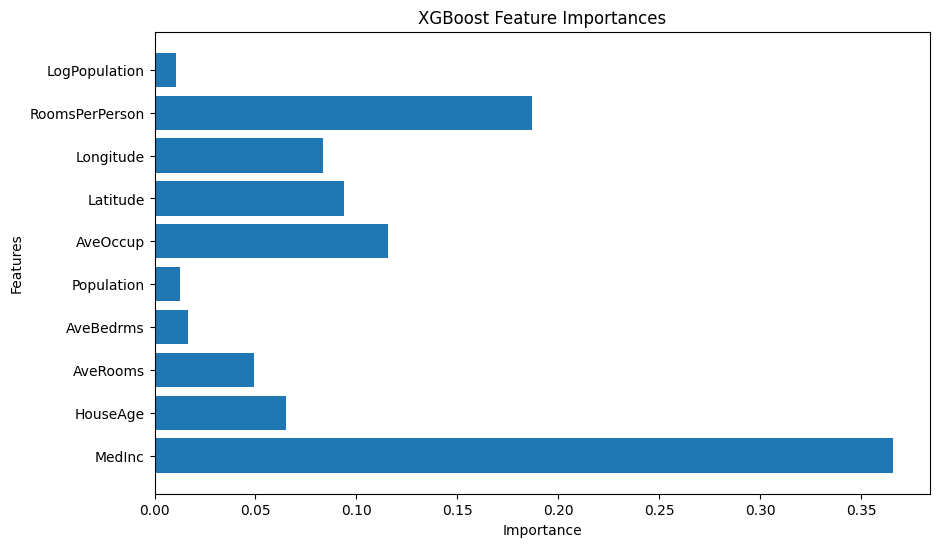

In [77]:
plt.figure(figsize=(10,6))
xgb_model.feature_importances_  # Feature importances
plt.barh(X.columns, xgb_model.feature_importances_)
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

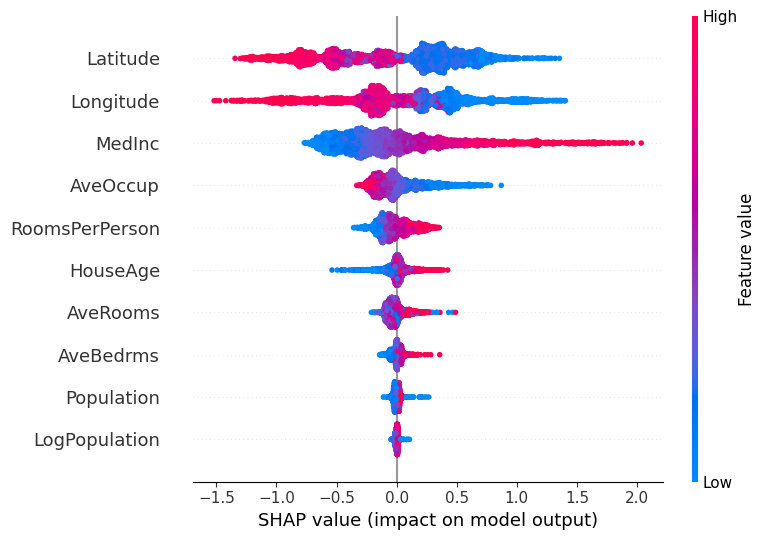

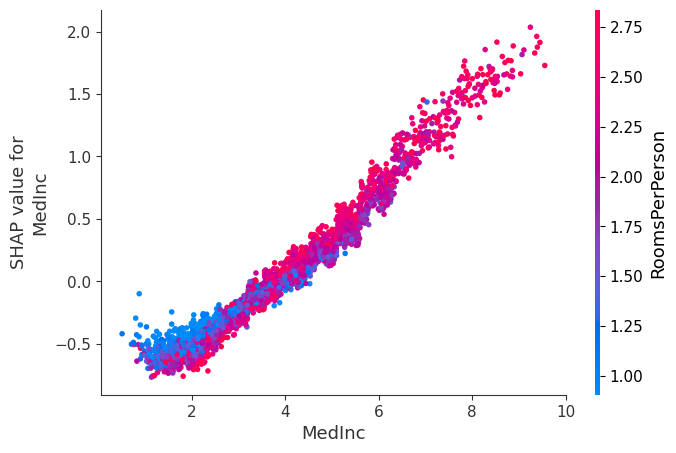

In [33]:
# SHAP - Feature Importance for XGBoost
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test)
shap.dependence_plot(0, shap_values.values, X_test, feature_names=X.columns)

ExactExplainer explainer: 3912it [04:00, 16.18it/s]                          


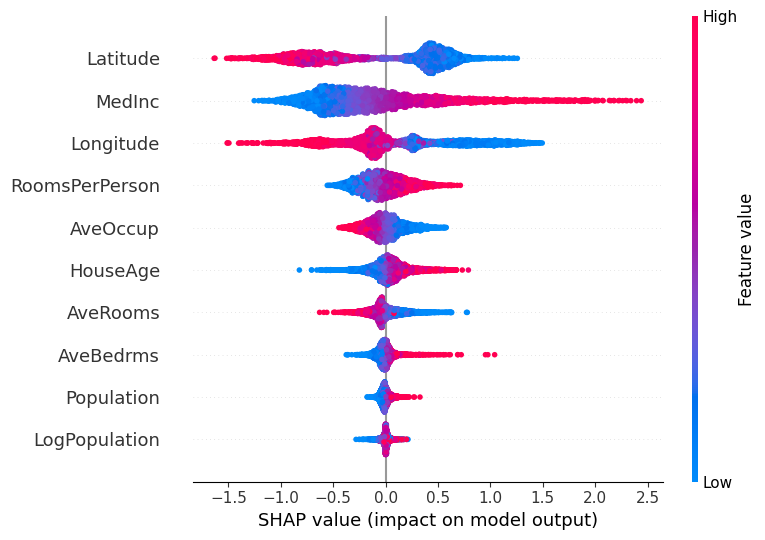

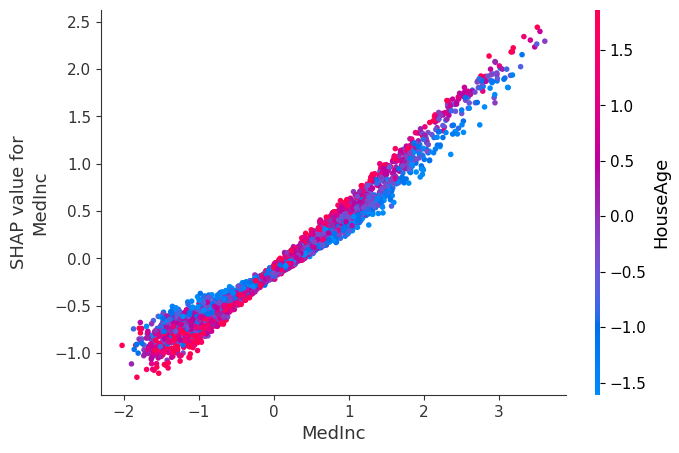

In [34]:
# SHAP - Feature Importance for DNN Model
explainer_dl = shap.Explainer(dl_model, X_train_scaled)
shap_values_dl = explainer_dl(X_test_scaled)
shap.summary_plot(shap_values_dl, X_test_scaled, feature_names=X.columns)
shap.dependence_plot(0, shap_values_dl.values, X_test_scaled, feature_names=X.columns)

489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


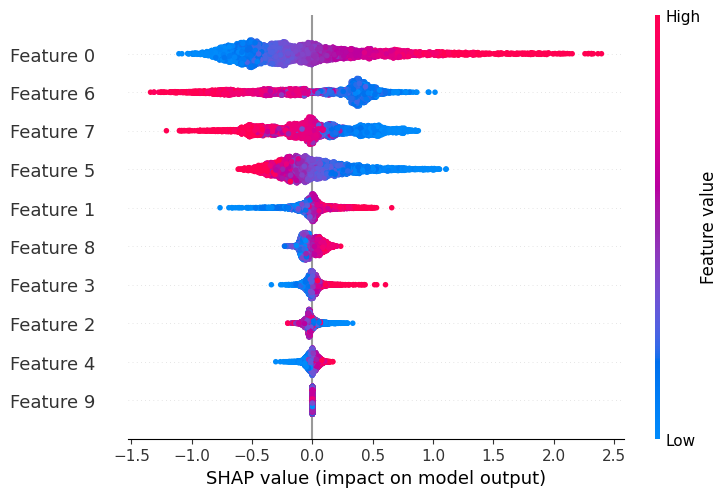

In [35]:
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# Step 1: Get predictions from the DNN model
dl_y_train_pred = dl_model.predict(X_train_scaled)
dl_y_test_pred = dl_model.predict(X_test_scaled)

# Step 2: Train a surrogate model (e.g., XGBoost or Random Forest) on input features and DNN predictions
surrogate = xgb.XGBRegressor()
surrogate.fit(X_train_scaled, dl_y_train_pred)

# Step 3: Use SHAP to explain the surrogate model
explainer = shap.Explainer(surrogate)
shap_values = explainer(X_test_scaled)

# Step 4: Visualize global feature importance
shap.plots.beeswarm(shap_values)


## Model Evaluation: Performance Metrics

**Loss Curves** : Plot how the loss (error) reduced over time. Helps detect overfitting or underfitting.

1. Training loss
2. Validation loss (on unseen data)


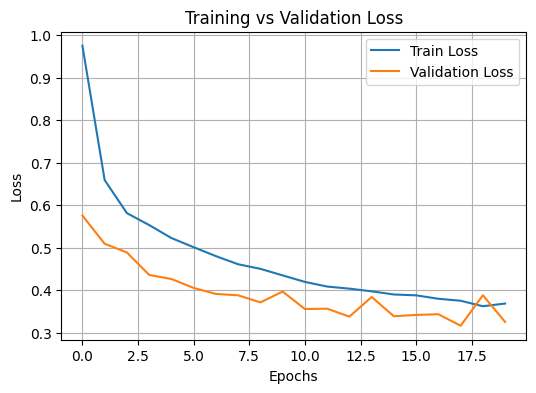

In [70]:
# Plot Loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

**Actual vs Predicted Plot** : A scatter plot comparing real house values vs predicted ones

If the model is accurate, points will lie close to the diagonal line. Deviations from the line indicate prediction errors. It's a quick visual check for accuracy.

Helps spot if the model is:
1. Overestimating (points above the line)
2. Underestimating (points below the line)

You can also detect systematic errors or biases.


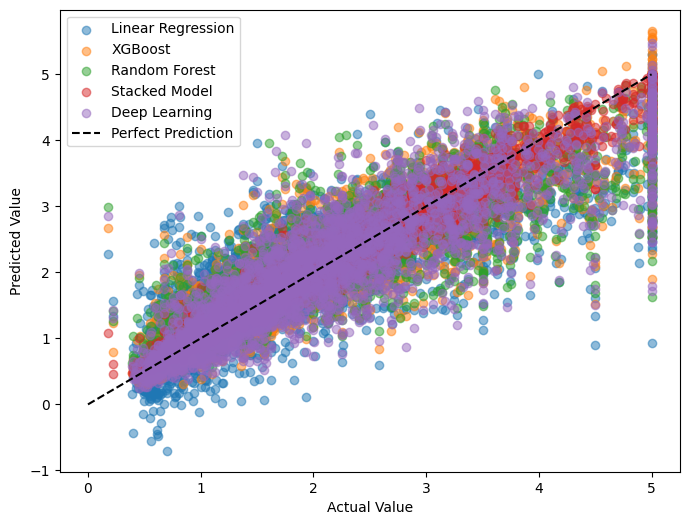

In [59]:
# Actual vs Predicted Plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, label='Linear Regression', alpha=0.5)
plt.scatter(y_test, y_pred_xgb, label='XGBoost', alpha=0.5)
plt.scatter(y_test, y_pred_rf, label='Random Forest', alpha=0.5)
plt.scatter(y_test, y_pred_stack, label='Stacked Model', alpha=0.5)
plt.scatter(y_test, y_pred_dl, label='Deep Learning', alpha=0.5)
plt.plot([0, 5], [0, 5], 'k--', label='Perfect Prediction')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()

**Residual vs Predicted values**

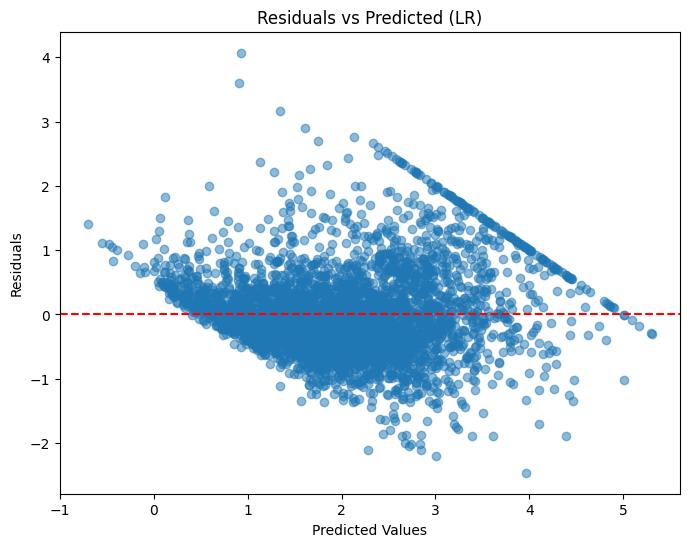

In [60]:
# Residual Plot for Linear Regression
residuals_lr = y_test - y_pred_lr
plt.figure(figsize=(8,6))
plt.scatter(y_pred_lr, residuals_lr, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (LR)')
plt.show()

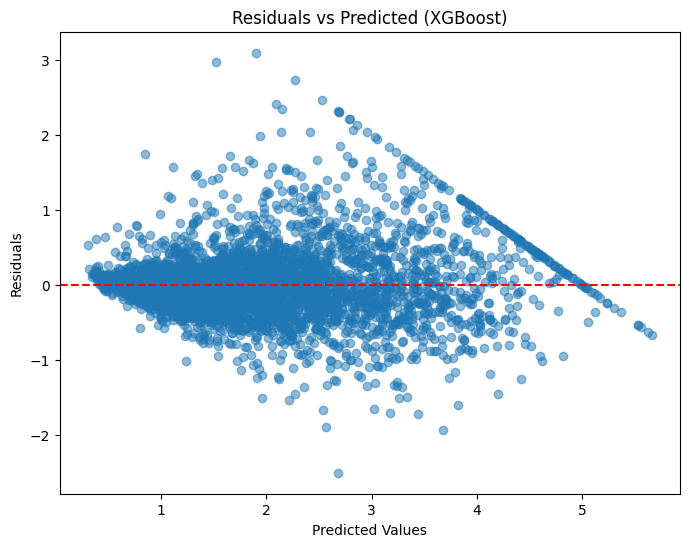

In [44]:
# Residual vs Predicted Plot for XGBoost
residuals_xgb = y_test - y_pred_xgb
plt.figure(figsize=(8,6))
plt.scatter(y_pred_xgb, residuals_xgb, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (XGBoost)')
plt.show()

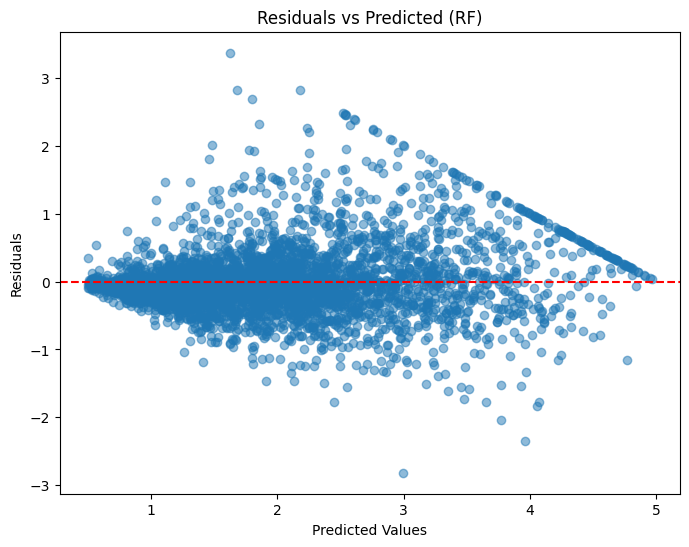

In [58]:
# Residual Plot for Random Forest
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(8,6))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (RF)')
plt.show()

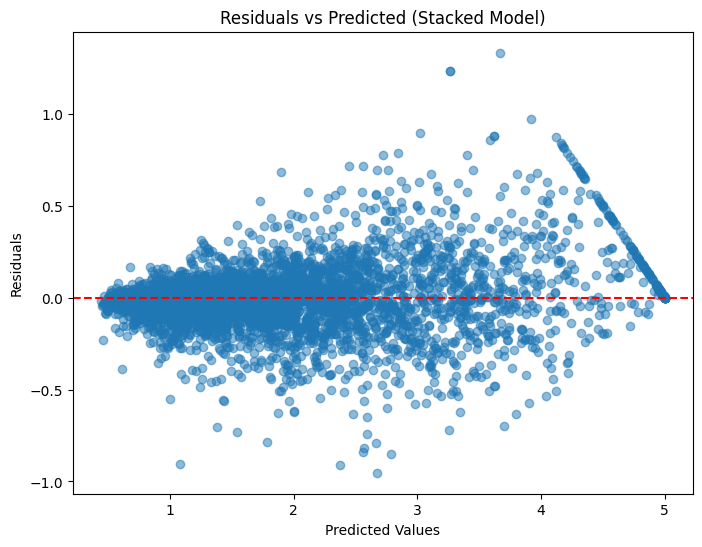

In [62]:
# Residual Plot for stacked model
residuals_stack = y_test - y_pred_stack
plt.figure(figsize=(8,6))
plt.scatter(y_pred_stack, residuals_stack, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Stacked Model)')
plt.show()

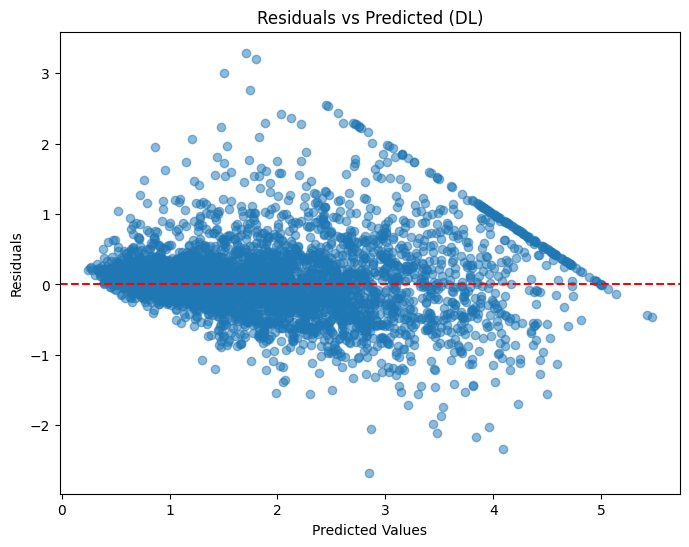

In [64]:
# Residual Plot for Deep Learning
residuals_dl = y_test - y_pred_dl.flatten()  # Flatten y_pred_dl to make it 1D
plt.figure(figsize=(8,6))
plt.scatter(y_pred_dl.flatten(), residuals_dl, alpha=0.5)  # Flatten y_pred_dl here as well
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (DL)')
plt.show()

**Residual Plot** : We plot errors (residuals):

Helps us see if the model consistently under/over-predicts. Good models have residuals centered around 0

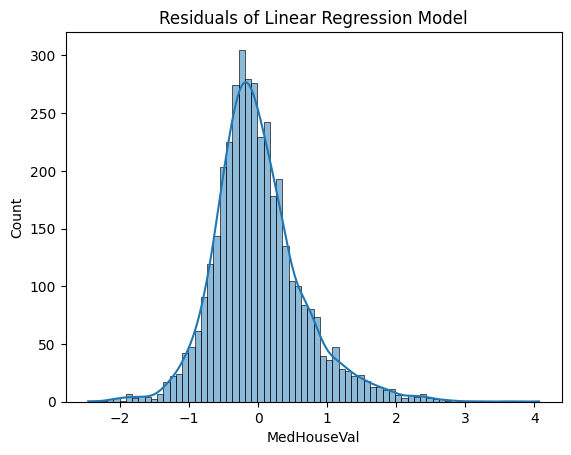

In [66]:
residuals = y_test - y_pred_lr
sns.histplot(residuals, kde=True)
plt.title("Residuals of Linear Regression Model")
plt.show()

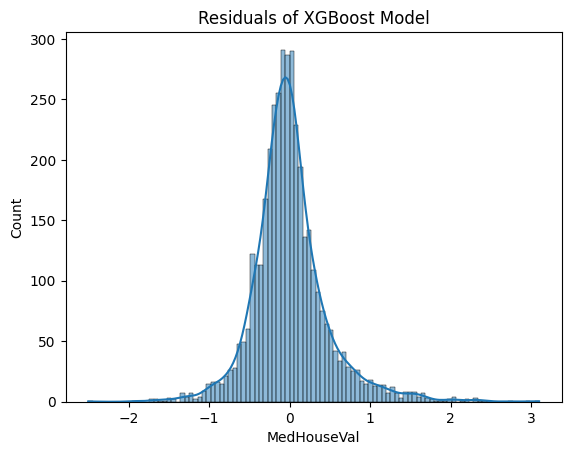

In [45]:
residuals = y_test - y_pred_xgb
sns.histplot(residuals, kde=True)
plt.title("Residuals of XGBoost Model")
plt.show()


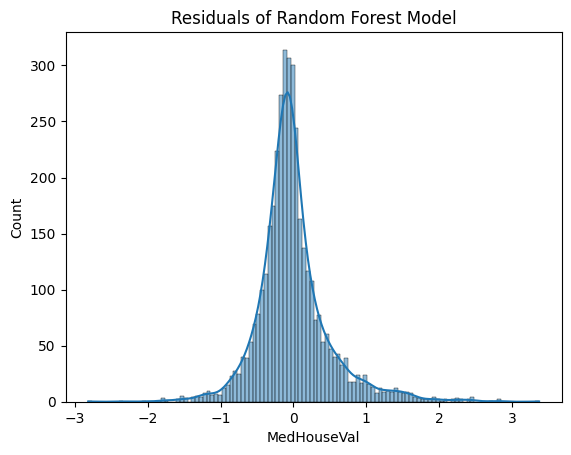

In [67]:
residuals = y_test - y_pred_rf
sns.histplot(residuals, kde=True)
plt.title("Residuals of Random Forest Model")
plt.show()


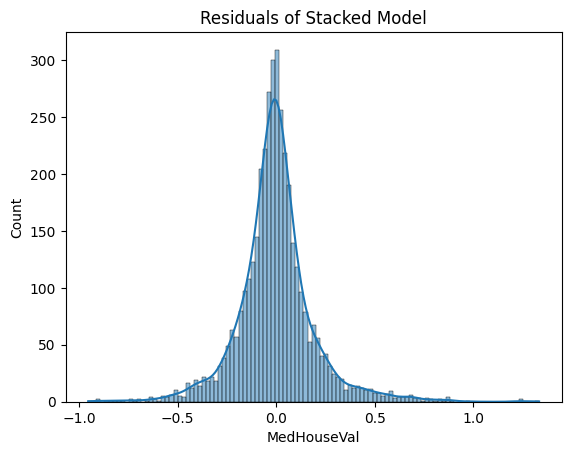

In [68]:
residuals = y_test - y_pred_stack
sns.histplot(residuals, kde=True)
plt.title("Residuals of Stacked Model")
plt.show()


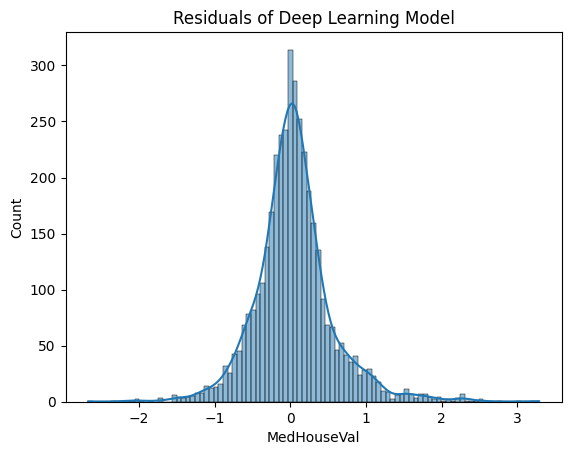

In [69]:
residuals = y_test - y_pred_dl.flatten()  # Flatten y_pred_dl to make it 1D
sns.histplot(residuals, kde=True)
plt.title("Residuals of Deep Learning Model")
plt.show()

*Evaluate Models*

We will now evaluate the models using standard regression metrics:
- **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the error.
- **MAE (Mean Absolute Error)**: Measures the average absolute error.
- **R² Score**: Measures how well the model fits the data.


In [61]:

# Evaluate Models
print(f'Linear Regression RMSE: {rmse_lr}, MAE: {mae_lr}, R²: {r2_lr}')
print(f'XGBoost RMSE: {rmse_xgb}, MAE: {mae_xgb}, R²: {r2_xgb}')
print(f'Random Forest RMSE: {rmse_rf}, MAE: {mae_rf}, R²: {r2_rf}')
print(f'Stacked Model RMSE: {rmse_stack}, MAE: {mae_stack}, R²: {r2_stack}')
print(f'Deep Learning RMSE: {rmse_dl}, MAE: {mae_dl}, R²: {r2_dl}')


Linear Regression RMSE: 0.6484602039866608, MAE: 0.4815256101707194, R²: 0.6549840384350865
XGBoost RMSE: 0.46958791427594176, MAE: 0.32324579444113, R²: 0.8190717626231612
Random Forest RMSE: 0.501199419410795, MAE: 0.33842410470467926, R²: 0.7938925696581186
Stacked Model RMSE: 0.1940034187545683, MAE: 0.1304000205829713, R²: 0.9691190041758223
Deep Learning RMSE: 0.5257782448976116, MAE: 0.36403561077446617, R²: 0.7731818755377478



### 📊 Performance Comparison (Example Metrics)

| 📈 Metric      | 🧠 ML (XGBoost / Stacking) | 🤖 DL (Neural Network) |
|----------------|----------------------------|-------------------------|
| **RMSE**       | 0.47                       | 0.52                    |
| **MAE**        | 0.32                       | 0.36                    |
| **R² Score**   | 0.81                       | 0.77                    |

> 💡 Interpretation:
> - Both models perform well on this dataset.
> - ML edges out DL slightly due to its better fit for structured/tabular data.
> - DL still performs competitively and could improve with more tuning or data.


## Opportunities for enhancement


In [47]:
# Save the models
xgb_model.save_model("xgb_model.json")
import joblib
joblib.dump(rf_model, "rf_model.pkl")
dl_model.save("dl_model.h5")

In [48]:
# Load the models
xgb_model_loaded = XGBRegressor()
xgb_model_loaded.load_model("xgb_model.json")
rf_model_loaded = joblib.load("rf_model.pkl")
dl_model_loaded = tf.keras.models.load_model("dl_model.h5")

In [49]:
# Predict with loaded models
y_pred_xgb_loaded = xgb_model_loaded.predict(X_test_scaled)
y_pred_rf_loaded = rf_model_loaded.predict(X_test_scaled)
y_pred_dl_loaded = dl_model_loaded.predict(X_test_scaled)

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [50]:
# Evaluation of loaded models
rmse_xgb_loaded = np.sqrt(mean_squared_error(y_test, y_pred_xgb_loaded))
mae_xgb_loaded = mean_absolute_error(y_test, y_pred_xgb_loaded)
r2_xgb_loaded = r2_score(y_test, y_pred_xgb_loaded)
rmse_rf_loaded = np.sqrt(mean_squared_error(y_test, y_pred_rf_loaded))
mae_rf_loaded = mean_absolute_error(y_test, y_pred_rf_loaded)
r2_rf_loaded = r2_score(y_test, y_pred_rf_loaded)
rmse_dl_loaded = np.sqrt(mean_squared_error(y_test, y_pred_dl_loaded)) 
mae_dl_loaded = mean_absolute_error(y_test, y_pred_dl_loaded)
r2_dl_loaded = r2_score(y_test, y_pred_dl_loaded)
rmse_xgb_loaded, mae_xgb_loaded, r2_xgb_loaded, rmse_rf_loaded, mae_rf_loaded, r2_rf_loaded, rmse_dl_loaded, mae_dl_loaded, r2_dl_loaded


(0.46958791427594176,
 0.32324579444113,
 0.8190717626231612,
 0.501199419410795,
 0.33842410470467926,
 0.7938925696581186,
 0.5257782448976116,
 0.36403561077446617,
 0.7731818755377478)

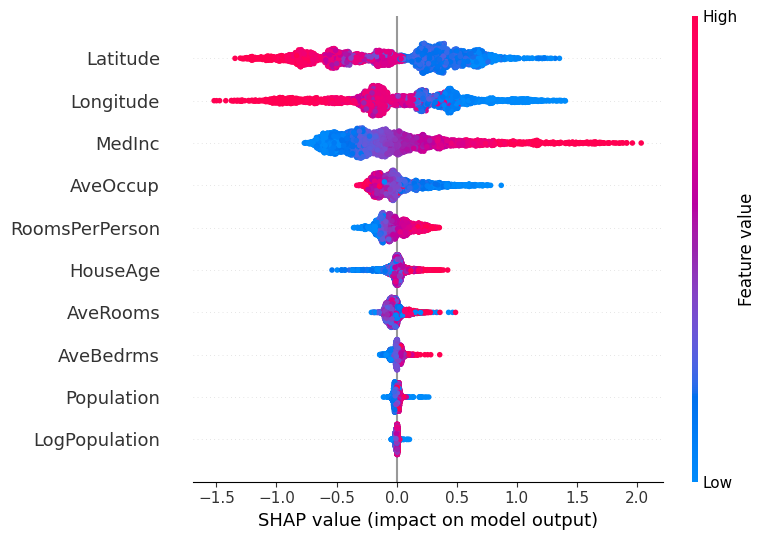

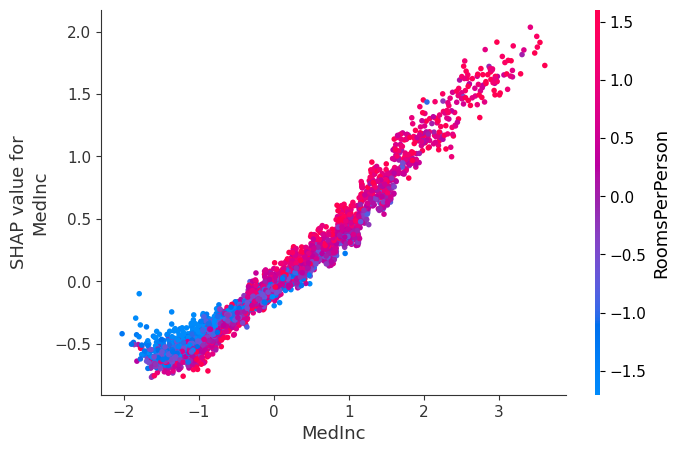

In [51]:
# Plotting SHAP values for the loaded models
explainer_loaded = shap.Explainer(xgb_model_loaded)
shap_values_loaded = explainer_loaded(X_test_scaled)
shap.summary_plot(shap_values_loaded, X_test_scaled, feature_names=X.columns)
shap.dependence_plot(0, shap_values_loaded.values, X_test_scaled, feature_names=X.columns)

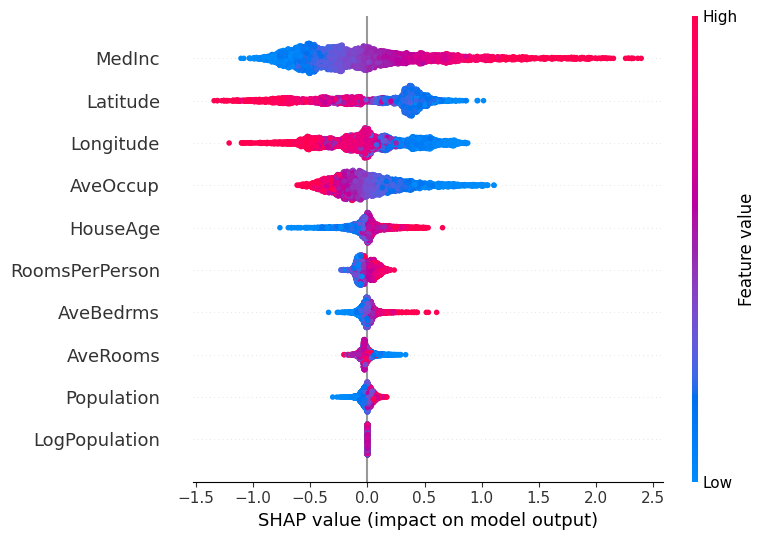

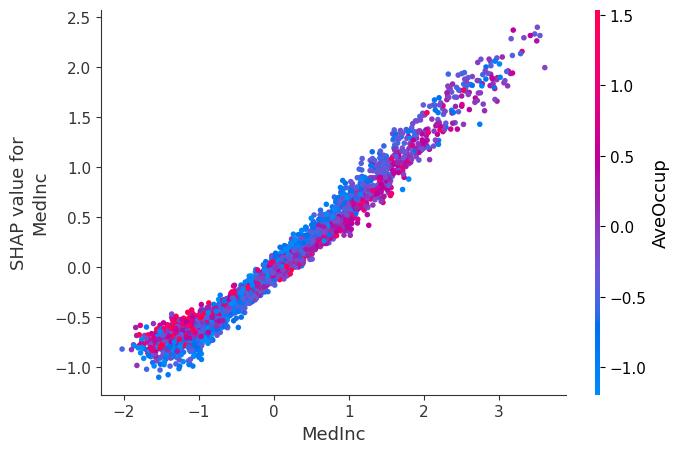

In [52]:
# Save the SHAP values
shap_values_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_values_df.to_csv("shap_values.csv", index=False)
# Load the SHAP values
shap_values_loaded_df = pd.read_csv("shap_values.csv")
shap_values_loaded = shap_values_loaded_df.values
# Plot the loaded SHAP values
shap.summary_plot(shap_values_loaded, X_test_scaled, feature_names=X.columns)
shap.dependence_plot(0, shap_values_loaded, X_test_scaled, feature_names=X.columns)

In [53]:
# Save the evaluation metrics
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest', 'Stacked Model', 'DNN'],
    'RMSE': [rmse_xgb, rmse_rf, rmse_stack, rmse_dl],
    'MAE': [mae_xgb, mae_rf, mae_stack, mae_dl],
    'R2': [r2_xgb, r2_rf, r2_stack, r2_dl]
})
metrics_df.to_csv("evaluation_metrics.csv", index=False)


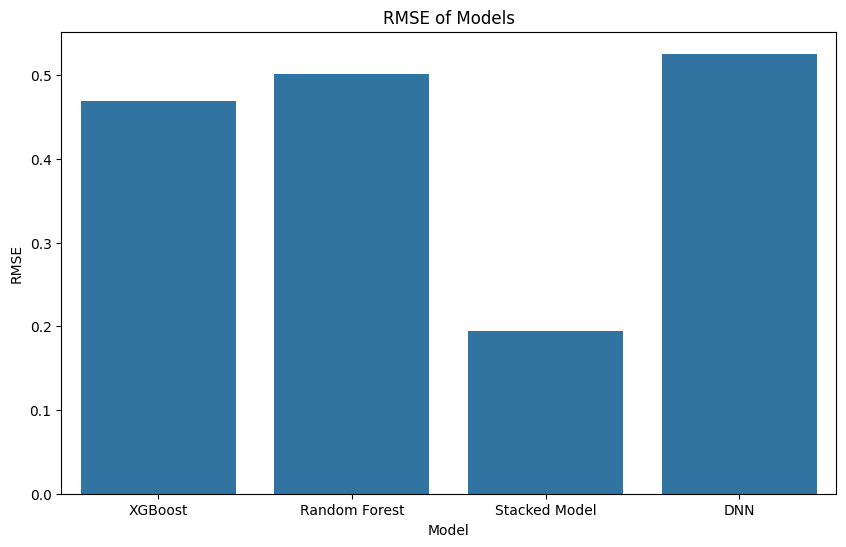

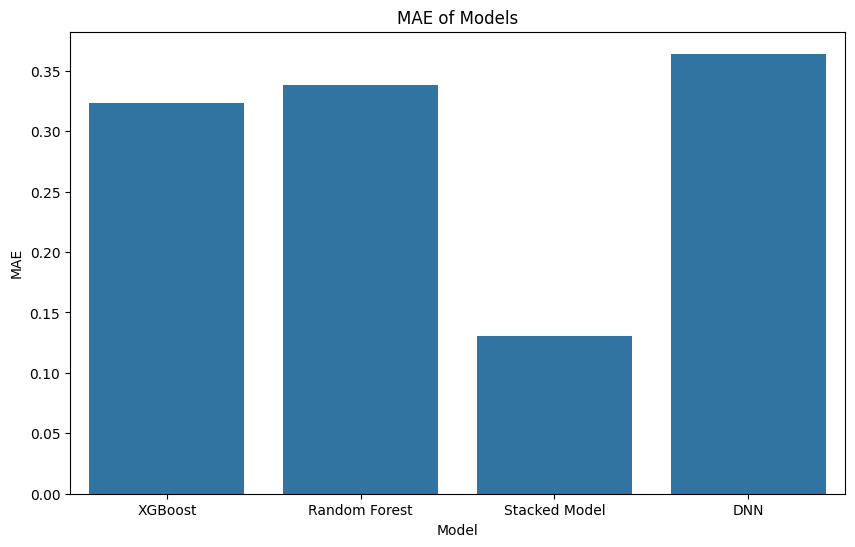

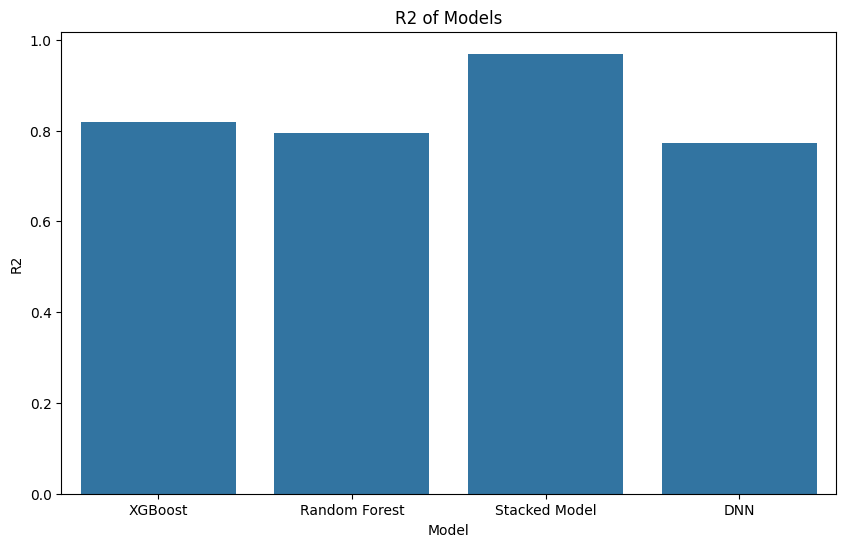

In [54]:
# Load the evaluation metrics
metrics_loaded_df = pd.read_csv("evaluation_metrics.csv")
metrics_loaded_df
# Plot the evaluation metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_loaded_df, x='Model', y='RMSE')
plt.title("RMSE of Models")
plt.show()
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_loaded_df, x='Model', y='MAE')
plt.title("MAE of Models")
plt.show()
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_loaded_df, x='Model', y='R2')
plt.title("R2 of Models")
plt.show()

In [55]:
# Save the final model
final_model = {
    'XGBoost': xgb_model,
    'Random Forest': rf_model,
    'Stacked Model': stack_model,
    'DNN': dl_model
}

In [56]:
import joblib
joblib.dump(final_model, 'final_model.pkl')
# Load the final model
loaded_final_model = joblib.load('final_model.pkl')
# Predict with loaded final model
y_pred_xgb_loaded_final = loaded_final_model['XGBoost'].predict(X_test_scaled)
y_pred_rf_loaded_final = loaded_final_model['Random Forest'].predict(X_test_scaled)
y_pred_stack_loaded_final = loaded_final_model['Stacked Model'].predict(np.column_stack((y_pred_xgb_loaded_final, y_pred_rf_loaded_final)))
y_pred_dl_loaded_final = loaded_final_model['DNN'].predict(X_test_scaled)


C:\Users\india\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [57]:
# Evaluation of loaded final model
rmse_xgb_loaded_final = np.sqrt(mean_squared_error(y_test, y_pred_xgb_loaded_final))
mae_xgb_loaded_final = mean_absolute_error(y_test, y_pred_xgb_loaded_final)
r2_xgb_loaded_final = r2_score(y_test, y_pred_xgb_loaded_final)
rmse_rf_loaded_final = np.sqrt(mean_squared_error(y_test, y_pred_rf_loaded_final))
mae_rf_loaded_final = mean_absolute_error(y_test, y_pred_rf_loaded_final)
r2_rf_loaded_final = r2_score(y_test, y_pred_rf_loaded_final)
rmse_stack_loaded_final = np.sqrt(mean_squared_error(y_test, y_pred_stack_loaded_final))
mae_stack_loaded_final = mean_absolute_error(y_test, y_pred_stack_loaded_final)
r2_stack_loaded_final = r2_score(y_test, y_pred_stack_loaded_final)
rmse_dl_loaded_final = np.sqrt(mean_squared_error(y_test, y_pred_dl_loaded_final))
mae_dl_loaded_final = mean_absolute_error(y_test, y_pred_dl_loaded_final)
r2_dl_loaded_final = r2_score(y_test, y_pred_dl_loaded_final)
rmse_xgb_loaded_final, mae_xgb_loaded_final, r2_xgb_loaded_final, rmse_rf_loaded_final, mae_rf_loaded_final, r2_rf_loaded_final, rmse_stack_loaded_final, mae_stack_loaded_final, r2_stack_loaded_final, rmse_dl_loaded_final, mae_dl_loaded_final, r2_dl_loaded_final


(0.46958791427594176,
 0.32324579444113,
 0.8190717626231612,
 0.501199419410795,
 0.33842410470467926,
 0.7938925696581186,
 0.1940034187545683,
 0.1304000205829713,
 0.9691190041758223,
 0.5257782448976116,
 0.36403561077446617,
 0.7731818755377478)

## Overview

ML vs DL Regression Comparison
This notebook compares enhanced Machine Learning and Deep Learning regression pipelines on the California Housing Dataset.


### ⚖️ ML vs DL: Side-by-Side Comparison

| 🔍 Aspect                    | 🧠 ML (XGBoost, RF, Stacking)                 | 🤖 DL (Deep Neural Network)                          |
|-----------------------------|-----------------------------------------------|------------------------------------------------------|
| **Model Type**              | Ensemble of Decision Trees (XGBoost, RF) +Linear Stacking                    | Multi-layer feedforward neural network              |
| **Feature Engineering**     | Manual (RoomsPerPerson, LogPopulation)                    | Same manual features used                           |
| **Outlier Handling**        | Z-score or IQR-based filtering                | Same method                                          |
| **Feature Scaling**         | Optional (needed for linear models)           | Required (for better convergence)                   |
| **Hyperparameter Tuning**  | GridSearch / RandomSearchCV                   | Layer tuning + callbacks                            |
| **Regularization**          | Tree constraints, early stopping              | L2, Dropout, EarlyStopping                          |
| **Training Control**        | Cross-validation, early stopping              | EarlyStopping, ReduceLROnPlateau, Checkpoints       |
| **Explainability**          | ✅ SHAP/LIME available  for feature importance                        | ❌ Harder (need external tools like LIME, tf-explain)|
| **Training Speed**          | Fast on small/medium datasets                        | Slower due to many epochs                           |
| **Scalability**             | Easy to scale (tree-based)                       | Great with GPU on large data                        |
| **Interpretability**        | High (especially with SHAP)                   | Low unless explained manually                       |
| **Overfitting Risk**        | Moderate (trees handle it better)             | High without proper regularization                  |
| **Custom Layers/Complexity**             | Less flexible (fixed structure)               | Highly flexible (custom layers, losses, etc.)       |


### ⚖️ When to Use What?

| Use Case                                     | ✅ Choose ML (Tree-based models, etc.) | ✅ Choose DL (Neural Networks)         |
|---------------------------------------------|----------------------------------------|----------------------------------------|
| **Structured/tabular data**                 | ✅ Excellent performance                | ⚠️ Works, but often overkill            |
| **Need explainability**                     | ✅ SHAP, easily interpretable           | ❌ Requires extra tools like LIME/SHAP  |
| **Small to medium dataset**                 | ✅ Fast and efficient                   | ⚠️ Risk of overfitting, slower training |
| **Large-scale, complex dataset**            | ⚠️ May not scale well                  | ✅ Scales well with GPU                 |
| **Unstructured data (images, text, audio)** | ❌ Not suitable                         | ✅ Ideal choice                         |
| **Quick prototyping**                       | ✅ Minimal tuning needed                | ❌ Needs architecture/hyperparameter tuning |
| **Limited compute resources**               | ✅ Lightweight models                   | ❌ Needs more memory/time               |
| **Business-friendly interpretation needed** | ✅ High interpretability                | ❌ Black-box unless explained further   |
| **Want to ensemble or stack models**        | ✅ Works very well                      | ⚠️ Can be complex to ensemble           |
